In [5]:
import os
import tweepy as tw
import pandas as pd
import yaml

import re
import unicodedata
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

# Step 1: Set up Twitter API access
Set up the project here: https://developer.twitter.com/en/portal/projects-and-apps

Using this site as reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

In [6]:
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

In [8]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# Step 2: Get tweets and transform into dataframe

In [10]:
# Reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

# define parameters for API request
search_word = "#covidcanada"
num_of_tweets = 1000
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode = "extended",
                    lang=language).items(num_of_tweets)

In [11]:
# Twitter API data dictionary: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet

# Get column names
api_colnames_call = api.search(q=search_word, count=num_of_tweets)
json_data = [c._json for c in api_colnames_call]

# create dataframe from JSON result
api_colnames = pd.json_normalize(json_data)

# print all column names
for col in api_colnames.columns:
    print(col)

created_at
id
id_str
text
truncated
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
metadata.iso_language_code
metadata.result_type
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.url.urls
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_h

In [12]:
# Specify which columns to pull from API
tweet_metadata = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

print(tweet_metadata[:2])

[[datetime.datetime(2021, 6, 5, 22, 29, 27), 1401305194340622340, 'Delta variant heightens urgency for second doses to stop spread, scientists say https://t.co/BCUAUKsZST via @CTVNews #COVIDCanada #COVID19Canada #B1617', 'iChinadian', 0, 0], [datetime.datetime(2021, 6, 5, 22, 28, 49), 1401305034546028546, 'Race between vaccines and variants is back on as B.1.617 takes hold in Canada | CBC News https://t.co/1L4rhsvnqw #B1617 #COVIDCanada #COVID19Canada', 'iChinadian', 0, 0]]


In [13]:
# Create a pandas dataframe
df_tweets_raw = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'full_text', 'user', 'rt_count', 'fav_count'])
df_tweets_raw['created_dt'] = df_tweets_raw['created_at'].dt.date

df_tweets_raw.head()

,created_at,id,full_text,user,rt_count,fav_count,created_dt
0,2021-06-05 22:29:27,1401305194340622340,Delta variant heightens urgency for second dos...,iChinadian,0,0,2021-06-05
1,2021-06-05 22:28:49,1401305034546028546,Race between vaccines and variants is back on ...,iChinadian,0,0,2021-06-05
2,2021-06-05 22:28:28,1401304946822193153,Canada secures more Pfizer shots as focus shif...,iChinadian,0,0,2021-06-05
3,2021-06-05 22:24:37,1401303977728241666,Ontario records slight drop in COVID-19 cases ...,iChinadian,0,0,2021-06-05
4,2021-06-05 13:48:45,1401174154821443588,"@GoldenKnights 🛑Well in Ontario,Canada we can ...",GHockeyCoach,0,6,2021-06-05


# Step 3: Basic exploratory data analysis (EDA)

In [14]:
print('Rows:', df_tweets_raw.shape[0], '\nColumns:', df_tweets_raw.shape[1])

Rows: 173 
Columns: 7


In [15]:
max_tweet_length = df_tweets_raw.full_text.apply(len).max()
print('Longest tweet is', max_tweet_length, 'characters long')

Longest tweet is 331 characters long


In [16]:
min_date = df_tweets_raw.created_at.min()
max_date = df_tweets_raw.created_at.max()

print('Min. date: ', min_date, '\nMax. date: ', max_date)

Min. date:  2021-05-28 19:30:05 
Max. date:  2021-06-05 22:29:27


In [20]:
df_tweets_raw.describe(include='all')

<ipython-input-20-4d9704376e2a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_tweets_raw.describe(include='all')


,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct
count,173,1.730000e+02,173,173,173.000000,173.000000,173,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
unique,172,NaN,173,52,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-06-01 03:06:15,NaN,Tam warns against easing measures as #COVID-19...,iChinadian,NaN,NaN,2021-05-29,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,1,54,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN
first,2021-05-28 19:30:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-06-05 22:29:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.399715e+18,NaN,NaN,0.358382,0.971098,NaN,198.959538,2.768786,4.751445,0.416185,0.410405,16.179191
std,NaN,8.504467e+14,NaN,NaN,0.926924,2.880221,NaN,60.135444,3.352153,3.131156,0.876153,0.848601,7.813020
min,NaN,1.398361e+18,NaN,NaN,0.000000,0.000000,NaN,54.000000,0.000000,1.000000,0.000000,0.000000,2.000000
25%,NaN,1.398980e+18,NaN,NaN,0.000000,0.000000,NaN,148.000000,1.000000,3.000000,0.000000,0.000000,12.000000


# Step 4: Feature Extraction (before text cleaning)
* Count of Stopwords
* Count of @ characters
* Count of Hashtag characters
* Count of Numeric characters
* Count of Punctuation
* Count of Emojis 😜
* Count of Emoticons :-)

In [21]:
# Load libraries
#!pip install -q wordcloud
#import wordcloud
from nltk.corpus import stopwords
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Step 4a: Pre-cleaning counts (easy)

In [19]:
# Easy ones: Stopwords, hashtags, numerics, uppercase, & punctuation

# Create pre-clean character count feature
df_tweets_raw['character_ct'] = df_tweets_raw.full_text.apply(lambda x: len(x))

# Create stopword count feature
df_tweets_raw['stopword_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x in stop]))

# Create hashtag count feature
df_tweets_raw['hashtag_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Create @ sign count feature
df_tweets_raw['atsign_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

# Create numeric count feature
df_tweets_raw['numeric_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.isdigit()]))

# Create an uppercase count feature
df_tweets_raw['stopword_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Create punctuation count feature
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

df_tweets_raw['punctuation_ct'] = df_tweets_raw.full_text.apply(lambda x: count_punct(x))


# See all new columns
df_tweets_raw[['full_text', 'stopword_ct', 'hashtag_ct', 'atsign_ct', 'numeric_ct', 'punctuation_ct', 'character_ct']].sort_values(by='stopword_ct', ascending=False).head(3)

,full_text,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,character_ct
144,I demand @JustinTrudeau @PattyHajdu @AnitaOakv...,18,4,6,0,19,277
165,3 DAYS! RACE Winners MAY 31\n\nMAY 28\n\nWEST...,18,4,0,3,54,308
95,MAY 31\n\nTOTAL INFECTIONS\n(by proportion of ...,17,6,0,1,50,275


## Step 4b: Pre-cleaning counts (hard)

In [128]:
# Harder ones: Emojis, Emoticons

#TODO Right now, this code gets distinct number of emojis... 
#TODO Change to total number of emojis used

# Load libraries for emoji & regex
import emoji
import regex
import re

# Define function to remove emojis
def count_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

# Emoji count 
df_tweets_raw['emoji_ct'] = df_tweets_raw.full_text.apply(lambda x: len(count_emoji(x)))

# See a few 
df_tweets_raw[['full_text', 'emoji_ct']].sort_values('emoji_ct',ascending=False).head(3)

,full_text,emoji_ct
108,@brianlilley Stop 🛑 Blaming #FordNation #Covid...,5
3,👋 @CPHO_Canada @CMOH_Alberta @shandro \nMaybe ...,2
114,@5BobbyArmstrong @fordnation @Franktmcveety Pe...,2


In [ ]:
# TODO: THIS
#   Write a function to identify all the emoticons, call it emoticon_ct

# See 3 rows
# df[['text','emoticon_ct']].head(3)



## Part 5: Data & Text Cleaning
* Change to lower case
* Remove punctuation, stopwords, URLs, html tags, emojis, emoticons
* Spell correction
* Explore & remove custom stopwords

In [129]:
# Create a copy to preserve the raw data
df_tweets = df_tweets_raw.copy()

# Sample the tweets
df_tweets_raw.full_text[26]

'COVID-19 variants have been given new names by the World Health Organization. Here are the new labels: https://t.co/PhpOOdtWdd\n\n#COVIDtoronto #COVID19ON #COVIDcanada https://t.co/4DWJpmfNgS'

In [101]:
# View more sample tweets
for i in range(0,5):
    print(str(i+1) + ') ' + df_tweets_raw.full_text[i] + '\n')

1) The ethics and concerns of disclosing the names of businesses where COVID-19 outbreaks have occurred. #COVID19 #pandemic #COVIDCanada #healthandsafety https://t.co/hX8MTXRtOp

2) @dubsndoo Because she’s the only one with #covidcanada

3) Today's coronavirus news: Toronto is opening more than 10,000 additional vaccination appointments for next week, and Ontario is again asking the federal government to strengthen border enforcement. https://t.co/fU8mLoabqg

#vaccineTO #COVIDtoronto #COVID19ON #COVIDcanada https://t.co/fRchXR4dwx

4) 👋 @CPHO_Canada @CMOH_Alberta @shandro 
Maybe you could check this out?  Please and thanks.

#COVIDCanada 
#COVID19AB 

👇🇨🇦 https://t.co/17k5jp25vt

5) Excited to sit down for another @ProjectCanary2 episode with @Melhathnofury on Sunday. Time to do some AB/BC bullshit catch-up #CovidCanada #CovidWest #BCPoli #ABPoli #BCEd #ABEd



## Step 5a: Convert tweets to lower case

In [130]:
# Convert transcripts to lower case
df_tweets['text_cleaned'] = df_tweets['full_text'].map(lambda x: x.lower())

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
covid-19 variants have been given new names by the world health organization. here are the new labels: https://t.co/phpoodtwdd

#covidtoronto #covid19on #covidcanada https://t.co/4dwjpmfngs


## Step 5b: Remove URLs, html tags, punctuation, stopwords, emojis, emoticons

In [131]:
# Remove tweet URLs
df_tweets['text_cleaned'] = df_tweets.text_cleaned.map(lambda x: re.sub(r'https\:\/\/t\.co\/*\w*', '', x, flags=re.MULTILINE).strip())

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
covid-19 variants have been given new names by the world health organization. here are the new labels: 

#covidtoronto #covid19on #covidcanada


In [132]:
# Remove punctuation
df_tweets['text_cleaned'] = df_tweets.text_cleaned.str.replace('[^\w\s]','')

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
covid19 variants have been given new names by the world health organization here are the new labels 

covidtoronto covid19on covidcanada
<ipython-input-132-3fcf730612d2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets['text_cleaned'] = df_tweets.text_cleaned.str.replace('[^\w\s]','')


In [133]:
# Remove stopwords (start with library to identify stopwords)
from nltk.corpus import stopwords

# Define english & french stopwords 
stop_en = stopwords.words('english')
stop_fr = stopwords.words('french')

# Remove english & french stopwords
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: " ".join(x for x in x.split() if x not in stop_en))
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: " ".join(x for x in x.split() if x not in stop_fr))

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
covid19 variants given new names world health organization new labels covidtoronto covid19on covidcanada


In [134]:
# Define function to remove emojis --> e.g. 😜
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove all emojis
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: remove_emoji(x))

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
covid19 variants given new names world health organization new labels covidtoronto covid19on covidcanada


In [135]:
# Define function to remove emoticons --> e.g. :-)

# Libraries
!pip install emot
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Function for removing emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

# Remove all emoticons
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: remove_emoticons(x))

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
covid19 variants given new names world health organization new labels covidtoronto covid19on covidcanada
You should consider upgrading via the 'c:\users\dofayad\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## Step 5c: Tokenize and lemmatize tweets
Tokenization parses tweets into individual words and lemmatization removes inflectional endings (ie. endings that add grammatical meaning). These methods prepare the data for word frequency and n-gram analysis.

Methods used below reference this post: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

In [136]:
def basic_clean(text):
    """
    A simple function to clean up the data. All the words that
    are not designated as a stop word are then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore'))
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(df_tweets['text_cleaned'].tolist())))
words[:15]

['ethic',
 'concern',
 'disclosing',
 'name',
 'business',
 'covid19',
 'outbreak',
 'occurred',
 'covid19',
 'pandemic',
 'covidcanada',
 'healthandsafety',
 'dubsndoo',
 'shes',
 'one']

## Step 5d: Word correction (needs work & review!)

In [ ]:
#TODO Check to see if this worked as intended...

# Spell correction 
from textblob import TextBlob
df_tweets['text_cleaned'] = df_tweets.text_cleaned.[:5].apply(lambda x: str(TextBlob(x).correct()))

# Step 6: Text analytics (analyze tweets)

## Step 6a: Word frequencies and n-grams

In [137]:
def tweets_ngrams(n, top_n):
    result = (pd.Series(nltk.ngrams(words, n)).value_counts())[:top_n]
    return result

word_series = tweets_ngrams(1, 15)
bigram_series = tweets_ngrams(2, 15)
trigram_series = tweets_ngrams(3, 15)

bigram_series

(covid19on, covidcanada)        25
(covidcanada, covid19canada)    22
(covidtoronto, covid19on)       21
(covidcanada, covidbc)          20
(covid19, case)                 18
(covidbc, covidab)              16
(covid19, covidcanada)          15
(covidab, covidsk)              14
(cbc, news)                     14
(covid19, vaccine)              13
(vaccine, dos)                  13
(covidbc, covidcanada)          12
(covid19bc, covid19canada)      11
(may, 31)                       11
(new, case)                     11
dtype: int64

In [ ]:
#TODO: visualize word frequencies in horizontal bar charts

In [138]:
sns.set_style('whitegrid')
%matplotlib inline

C:\Users\dofayad\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


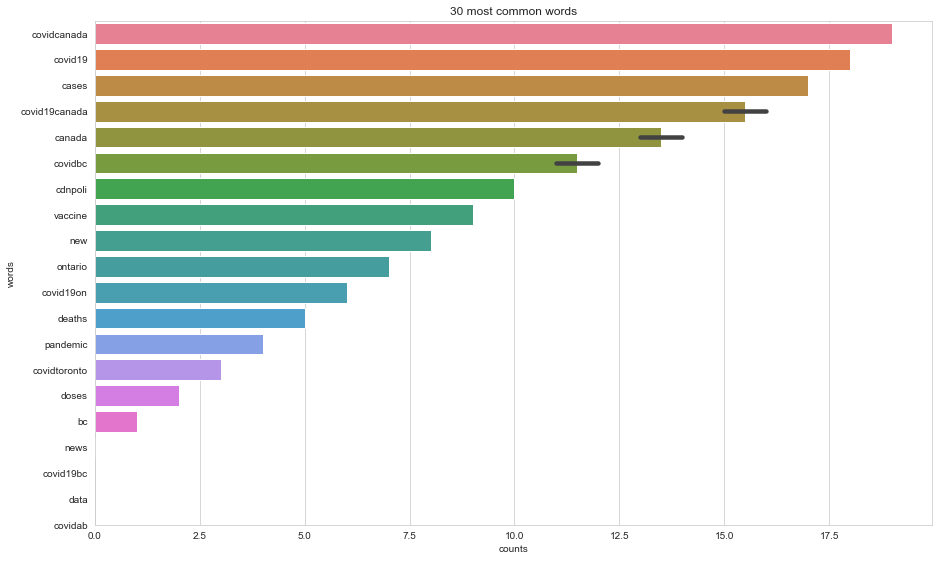

In [114]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl', orient = 'h')
    plt.yticks(x_pos, words) 
    plt.ylabel('words')
    plt.xlabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['text_cleaned'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

## Step 6b: Sentiment analysis

In [139]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
from textblob import TextBlob

# Make sure df_tweets.full_text is a string
df_tweets['full_text']= df_tweets.full_text.astype(str)

# Define functions
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

# Run functions and create columns in df_tweets
df_tweets['polarity'] = df_tweets.full_text.apply(pol)
df_tweets['subjectivity'] = df_tweets.full_text.apply(sub)

# Round scores
df_tweets['polarity'] = df_tweets.polarity.round(3)
df_tweets['subjectivity'] = df_tweets.subjectivity.round(3)


# See first 3 rows
df_tweets.head(3)

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,text_cleaned,polarity,subjectivity
0,2021-06-04 22:36:04,1400944471550967810,The ethics and concerns of disclosing the name...,EACOOntario,0,0,2021-06-04,174,2,4,0,0,11,0,ethics concerns disclosing names businesses co...,0.00,0.00
1,2021-06-04 22:11:55,1400938390128844802,@dubsndoo Because she’s the only one with #cov...,CarlsonRalph,0,0,2021-06-04,54,0,1,1,0,2,0,dubsndoo shes one covidcanada,0.00,1.00
2,2021-06-04 18:20:58,1400880272963518465,Today's coronavirus news: Toronto is opening m...,torontodotcom,0,0,2021-06-04,295,1,4,0,0,19,0,todays coronavirus news toronto opening 10000 ...,0.25,0.25


In [177]:
df_tweets['polarity'] = df_tweets.full_text.apply(pol)
df_tweets['subjectivity'] = df_tweets.full_text.apply(sub)

df_tweets.head(3)

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,text_cleaned,polarity,subjectivity
0,2021-06-04 22:36:04,1400944471550967810,The ethics and concerns of disclosing the name...,EACOOntario,0,0,2021-06-04,174,2,4,0,0,11,0,ethics concerns disclosing names businesses co...,0.00,0.00
1,2021-06-04 22:11:55,1400938390128844802,@dubsndoo Because she’s the only one with #cov...,CarlsonRalph,0,0,2021-06-04,54,0,1,1,0,2,0,dubsndoo shes one covidcanada,0.00,1.00
2,2021-06-04 18:20:58,1400880272963518465,Today's coronavirus news: Toronto is opening m...,torontodotcom,0,0,2021-06-04,295,1,4,0,0,19,0,todays coronavirus news toronto opening 10000 ...,0.25,0.25


In [187]:
df_tweets_grouped = df_tweets[['created_dt', 'id']].groupby(['created_dt']).agg(['nunique']).reset_index()

df_tweets_grouped.columns = ['tweet_date', 'tweets']

df_tweets_grouped

,tweet_date,tweets
0,2021-05-28,22
1,2021-05-29,29
2,2021-05-30,19
3,2021-05-31,15
4,2021-06-01,26
5,2021-06-02,21
6,2021-06-03,28
7,2021-06-04,17
